In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

# Message Passing as Matrix Multiplication

In [ ]:
A = np.array(
    [[0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]
)
A

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [ ]:
feats = np.arange(A.shape[0]).reshape((-1,1))+1
feats

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [ ]:
H = A @ feats
H

array([[ 2],
       [ 4],
       [11],
       [ 3],
       [ 3]])

## Scale neighborhood sum by neighborhood size (i.e. average values)

In [ ]:
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis=0))
D

array([[1., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
D_inv = np.linalg.inv(D)
D_inv

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
D_inv @ A

array([[0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ]])

In [ ]:
H_avg = D_inv @ A @ feats
H_avg

array([[2.        ],
       [2.        ],
       [3.66666667],
       [3.        ],
       [3.        ]])

## Normalized Adjacency Matrix
Ultimately want to define and build:

$$ \hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} $$


First, create $\tilde{A}$:
$$ \tilde{A} = A + I $$

In [ ]:
g = nx.from_numpy_array(A)
A_mod = A + np.eye(g.number_of_nodes())

Then create $ \tilde{D}^{-\frac{1}{2}} $, where $D$ is the diagonal degree matrix:

$$ (D)_{ij} = \delta_{i,j} \sum_k A_{i,k} $$

In [ ]:
# D for A_mod:
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, A_mod.sum(axis=1).flatten())

# Inverse square root of D:
D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

In [ ]:
D_mod

array([[2., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 2.]])

In [ ]:
D_mod_invroot

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.70710678, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70710678]])

I.e.: $\frac{1}{\sqrt{2}}$, $\frac{1}{\sqrt{3}}$, $\frac{1}{\sqrt{4}}$, ...etc

In [ ]:
node_labels = {i: i+1 for i in range(g.number_of_nodes())}
pos = nx.planar_layout(g)

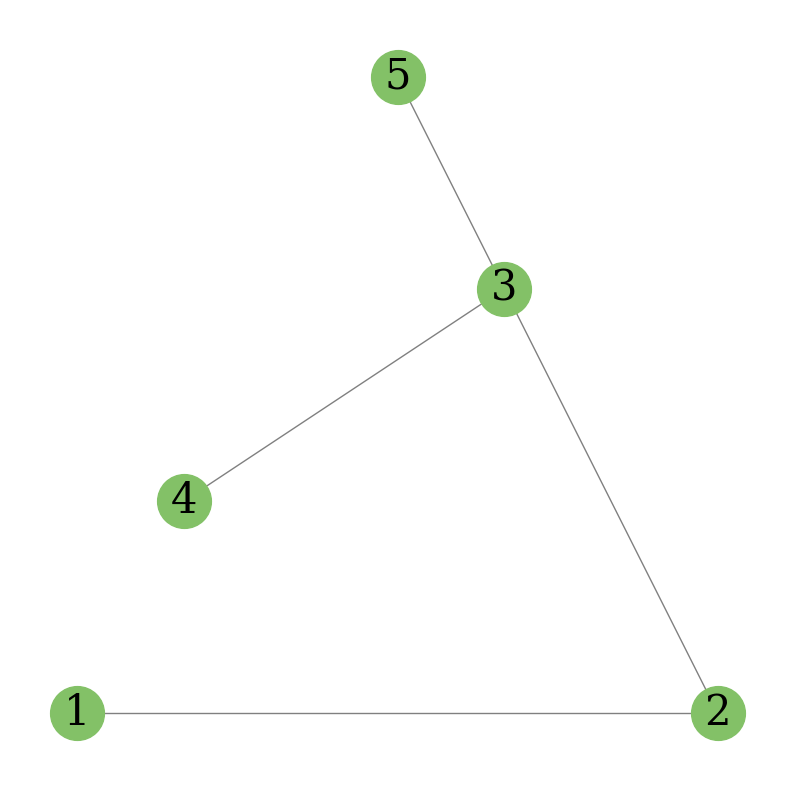

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    g, pos, with_labels=True,
    labels=node_labels,
    node_color='#83C167',
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)
plt.savefig('simple_graph.png', bbox_inches='tight', transparent=True)

In [ ]:
pos

{0: array([-0.875, -0.375]),
 1: array([ 1.   , -0.375]),
 2: array([0.375, 0.25 ]),
 3: array([-0.5625, -0.0625]),
 4: array([0.0625, 0.5625])}

Create $\hat{A}$:

$$ \hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} $$

$$ (\hat{A})_{i,j} = \frac{\tilde{A}_{i,j}}{\sqrt{\tilde{d_i} \tilde{d_j}}} $$

In [ ]:
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

# Water drop

In [ ]:
H = np.zeros((g.number_of_nodes(), 1))
H[0,0] = 1 # the "water drop"
iters = 10
results = [H.flatten()]
for i in range(iters):
    H = A_hat @ H
    results.append(H.flatten())

In [ ]:
print(f"Initial signal input: {results[0]}")
print(f"Final signal output after running {iters} steps of message-passing:  {results[-1]}")

Initial signal input: [1. 0. 0. 0. 0.]
Final signal output after running 10 steps of message-passing:  [0.18381719 0.20791335 0.20436693 0.13626176 0.13626176]


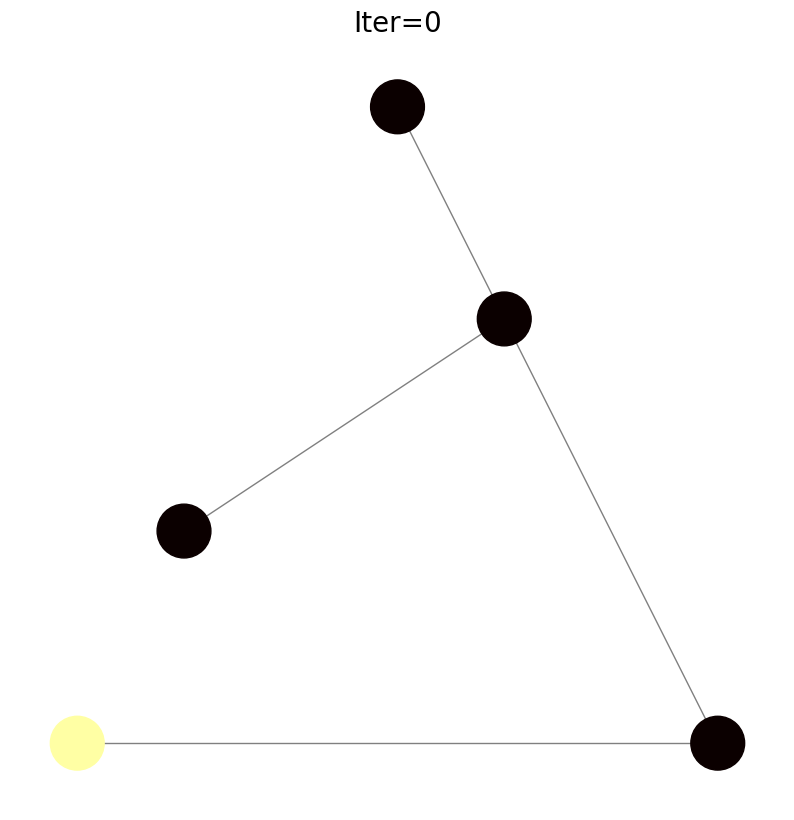

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray',
          'vmin': np.array(results).min(), 'vmax': np.array(results).max()*1.1}

def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)
    ax.set_title(f"Iter={idx}", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames=len(results), interval=1000, repeat=True)

In [ ]:
anim.save(
    'water_drop.mp4',
    dpi=600, bitrate=-1,
    savefig_kwargs={'transparent': True, 'facecolor': 'none'},
)

In [ ]:
HTML(anim.to_html5_video())